# Gradient-Based Interpretability Techniques
The goal of this notebook it to illustrate three gradient-based interpretability techniques:
1. Integrated gradient
2. Saliency map
3. Guided-GradCam

These techniques can help interpret what a model is focusing on in the input for a given classification.

The image used for these examples is my handsome dog Buddy!

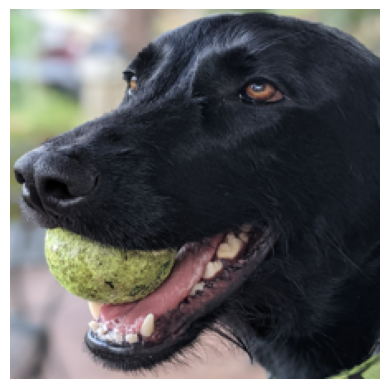

In [1]:
from captum.attr import IntegratedGradients, Saliency
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz
from captum.attr import NoiseTunnel
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from captum.attr import GuidedGradCam

import torchvision.models as models
def load_github_image(url):
    raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')
    response = requests.get(raw_url)
    if response.status_code == 200:
        image_buffer = BytesIO(response.content)
        image = Image.open(image_buffer).convert('RGB')
        return image
    else:
        print(f"Failed to load image. Status code: {response.status_code}")
        return None

image_url = "https://github.com/ZacCarrico/imgs/blob/131f743f0d428d6c2c47871cc4cff7e0ae5d460c/dog_w_ball.jpg"
original_img = load_github_image(image_url)
# don't show axes for the image
plt.axis('off')
# plot the image as 224 x 224 pixels to match the dimensions expected by the model
plt.imshow(original_img.resize((224, 224)))

In [2]:
# these are the transforms applied to ImageNet images and applying them is critical for good model performance
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
input_tensor = transform(original_img).unsqueeze(0)
transposed_image = np.transpose(input_tensor.squeeze().detach().numpy(), (1,2,0))

In [3]:
input_tensor.requires_grad_(True)
model = models.resnet34(weights='IMAGENET1K_V1')
model.eval()
model(input_tensor).topk(3)

torch.return_types.topk(
values=tensor([[11.3271, 11.0264,  9.8471]], grad_fn=<TopkBackward0>),
indices=tensor([[205, 852, 208]]))

## ImageNet class labels
205: flat-coated retriever  
852: tennis ball  
*208: Labrador retriever 

In [4]:
target_class = 208  # Labrador retriever

In [5]:
# Noise tunnel constants
NT_SAMPLES = 10
NT_SAMPLES_BATCH_SIZE = 5

# vizualize_image_attr
METHOD = "heat_map"
SIGN="absolute_value"
SHOW_COLORBAR=True
CUSTOM_CMAP = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.5, '#0000ff'),
                                                  (1, '#0000ff')], N=256)
partial_viz_img_attr = partial(viz.visualize_image_attr, method=METHOD, sign=SIGN, show_colorbar=SHOW_COLORBAR, cmap=CUSTOM_CMAP)

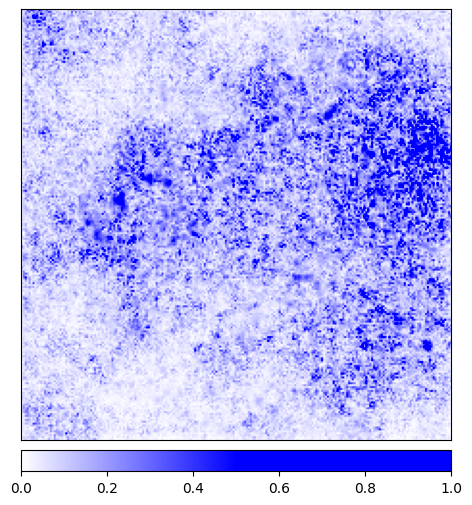

In [6]:
# Saliency Map
saliency = Saliency(model)
saliency_map = saliency.attribute(input_tensor, target_class).detach().squeeze().numpy()
transposed_saliency_map = np.transpose(saliency_map, (1,2,0))
saliency_plt = partial_viz_img_attr(transposed_saliency_map, transposed_image)

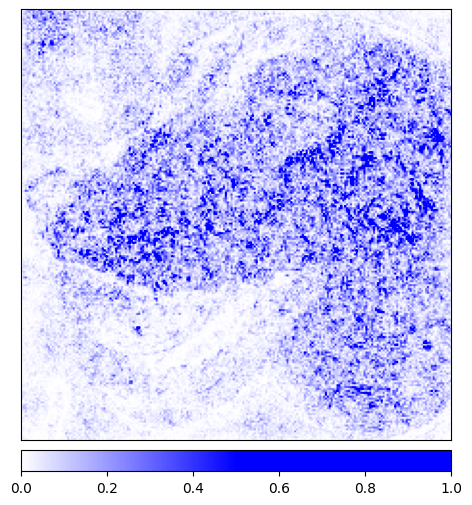

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [7]:
# Integrated gradients
ig = IntegratedGradients(model)
attributions, approximation_error = ig.attribute(input_tensor, target=target_class,
                                                return_convergence_delta=True)
transposed_attr_ig = np.transpose(attributions.squeeze().detach().numpy(), (1,2,0))

partial_viz_img_attr(attr=transposed_attr_ig, original_image=transposed_image)

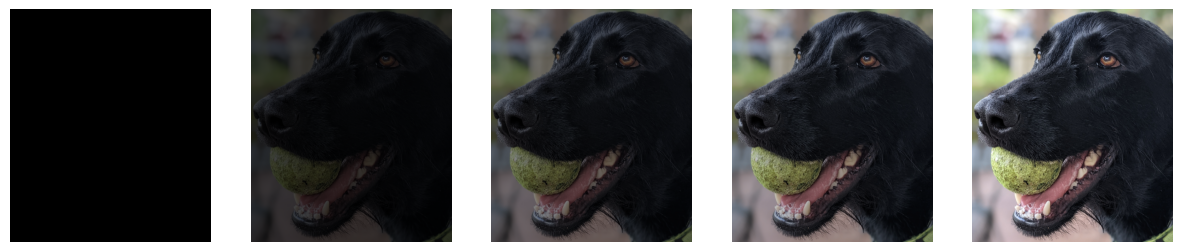

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # for reading images, if necessary

def generate_intermediate_images(input_image, baseline, num_steps=5):
    """
    Generate intermediate images for Integrated Gradients.

    Parameters:
    - input_image: numpy array of shape (H, W, 3), the original input RGB image
    - baseline: numpy array of shape (H, W, 3), the baseline image (e.g., black image)
    - num_steps: Number of steps for generating intermediate images

    Returns:
    - List of intermediate images, each of shape (H, W, 3)
    """
    # Ensure that input_image and baseline are numpy arrays with the same shape
    input_image = np.array(input_image, dtype=np.float32)
    baseline = np.array(baseline, dtype=np.float32)

    # Validate that the image and baseline have the same shape
    assert input_image.shape == baseline.shape, "Input image and baseline must have the same shape!"

    # Generate intermediate images
    intermediate_images = [baseline.astype(np.uint8)]  # Start with baseline image as the first one
    for step in range(1, num_steps + 1):
        # Interpolate between baseline and input image
        alpha = step / num_steps
        intermediate_image = baseline + alpha * (input_image - baseline)
        intermediate_images.append(intermediate_image.astype(np.uint8))  # Convert to uint8 for display

    return intermediate_images

# Example usage:
if __name__ == "__main__":
    # Create a baseline image (e.g., black image)
    baseline = np.zeros_like(original_img, dtype=np.uint8)

    # Generate the intermediate images
    num_steps = 4
    intermediate_images = generate_intermediate_images(original_img, baseline, num_steps=num_steps)

    # Display the intermediate images
    fig, axes = plt.subplots(1, num_steps + 1, figsize=(15, 8))  # +1 for the baseline image
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(intermediate_images[i])
        ax.axis('off')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


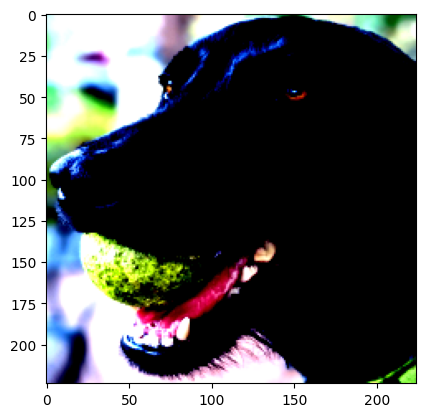

In [9]:
plt.imshow(transposed_image)

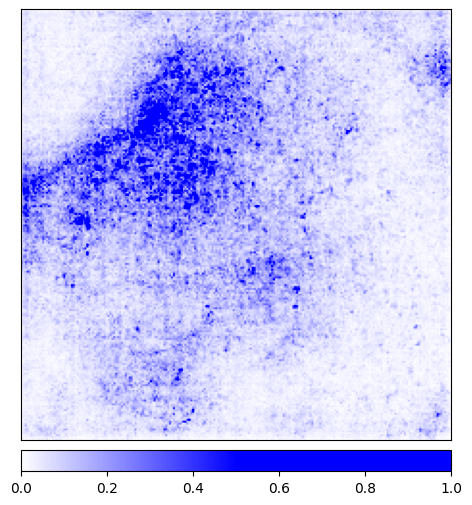

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [10]:
noise_tunnel = NoiseTunnel(saliency)
saliency_nt = noise_tunnel.attribute(input_tensor, nt_type='smoothgrad_sq', nt_samples_batch_size=NT_SAMPLES_BATCH_SIZE, nt_samples=NT_SAMPLES, target=target_class)
transposed_saliency_nt = np.transpose(saliency_nt.squeeze().numpy(), (1,2,0))
partial_viz_img_attr(transposed_saliency_nt, transposed_image)

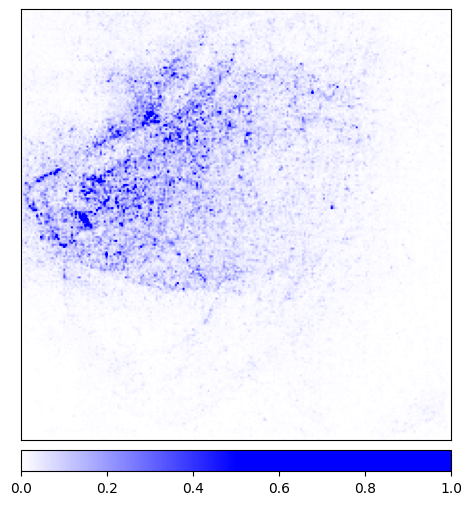

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [11]:
noise_tunnel = NoiseTunnel(ig)

attributions_ig_nt = noise_tunnel.attribute(input_tensor, nt_type='smoothgrad_sq', nt_samples_batch_size=NT_SAMPLES_BATCH_SIZE, nt_samples=NT_SAMPLES, target=target_class)
transposed_attr_ig_nt = np.transpose(attributions_ig_nt.squeeze().numpy(), (1,2,0))
partial_viz_img_attr(transposed_attr_ig_nt, transposed_image)

/Users/zcarrico/Library/Caches/pypoetry/virtualenvs/machine-learning-dags-dMe89Gof-py3.10/lib/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


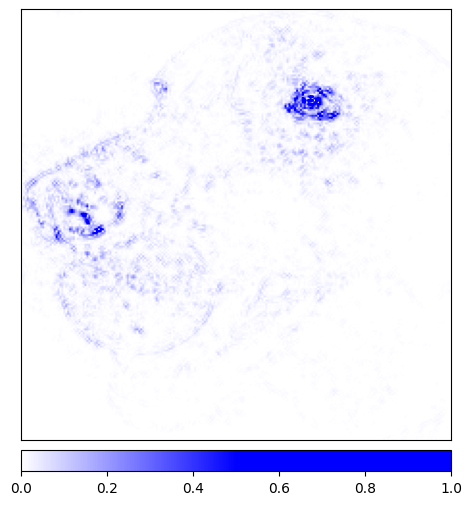

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [12]:
guided_grad_cam = GuidedGradCam(model, model.layer4)
attributions_gc = guided_grad_cam.attribute(input_tensor, target=target_class)
transposed_attr_gc = np.transpose(attributions_gc.squeeze(0).detach().numpy(), (1,2,0))

partial_viz_img_attr(transposed_attr_gc, transposed_image)

/Users/zcarrico/Library/Caches/pypoetry/virtualenvs/machine-learning-dags-dMe89Gof-py3.10/lib/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


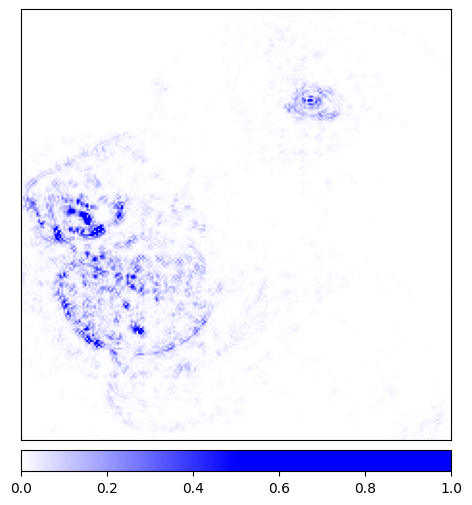

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [13]:
guided_grad_cam = GuidedGradCam(model, model.layer4)
attributions_gc = guided_grad_cam.attribute(input_tensor, target=852)  # 852 is the class index for tennis ball
transposed_attr_gc = np.transpose(attributions_gc.squeeze(0).detach().numpy(), (1,2,0))
partial_viz_img_attr(transposed_attr_gc, transposed_image)